In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [3]:
train_dir = '/content/drive/MyDrive/Datasets/Mri Images/Training/'
test_dir = '/content/drive/MyDrive/Datasets/Mri Images/Testing/'

In [4]:
import os

In [5]:
import os
from sklearn.utils import shuffle

# Correct paths (adjust if needed)
train_dir ="/content/drive/MyDrive/Colab Notebooks/Mri Images/Training"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing"

# Check if folders exist
assert os.path.exists(train_dir), f"Training folder not found at {train_dir}"
assert os.path.exists(test_dir), f"Testing folder not found at {test_dir}"

# Load and shuffle train data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):  # Ensure it's a folder
        for item_name in os.listdir(label_path):
            item_path = os.path.join(label_path, item_name)
            if os.path.isfile(item_path): # Ensure it's a file, not a directory
                train_paths.append(item_path)
                train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle test data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for item_name in os.listdir(label_path):
            item_path = os.path.join(label_path, item_name)
            if os.path.isfile(item_path): # Ensure it's a file, not a directory
                test_paths.append(item_path)
                test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

Training images: 5712
Testing images: 1311


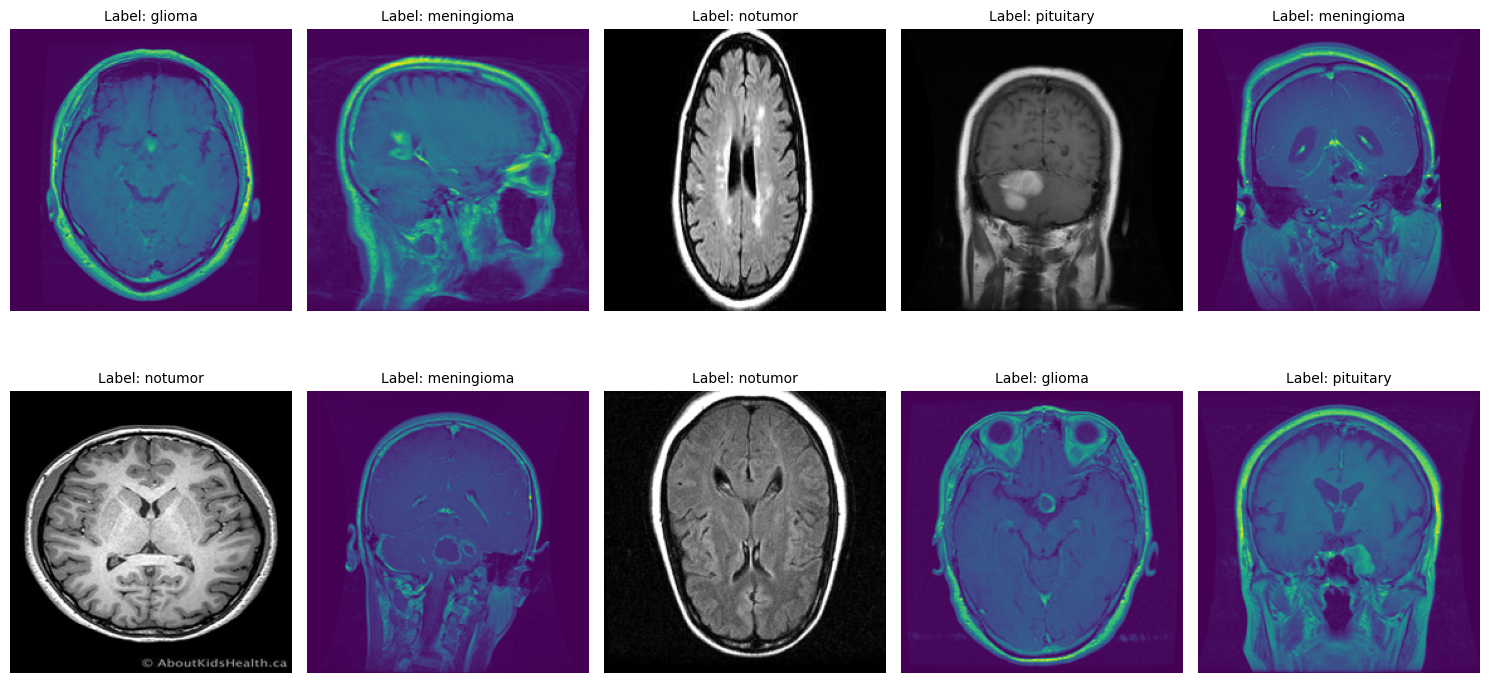

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [8]:
def datagen(paths, labels, batch_size):
    while True:  # Infinite loop so the generator never stops
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            batch_images = open_images(batch_paths)
            batch_labels = encode_label(batch_labels)

            yield np.array(batch_images), np.array(batch_labels)

In [9]:
import math

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import os
import math

# Image size
IMAGE_SIZE = 128

# Load VGG16 base model (without top classifier)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 3 layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build final model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(os.listdir(train_dir)), activation='softmax')
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

# Training parameters
batch_size = 20
steps = math.ceil(len(train_paths) / batch_size)
epochs = 5

# ✅ Corrected training code (no epochs inside datagen!)
history = model.fit(
    datagen(train_paths, train_labels, batch_size=batch_size),
    epochs=epochs,
    steps_per_epoch=steps
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 2254s 8s/step - loss: 0.6557 - sparse_categorical_accuracy: 0.7369
Epoch 2/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1391s 5s/step - loss: 0.2285 - sparse_categorical_accuracy: 0.9115
Epoch 3/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1388s 5s/step - loss: 0.1532 - sparse_categorical_accuracy: 0.9450
Epoch 4/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1384s 5s/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9611
Epoch 5/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 1380s 5s/step - loss: 0.0919 - sparse_categorical_accuracy: 0.9661


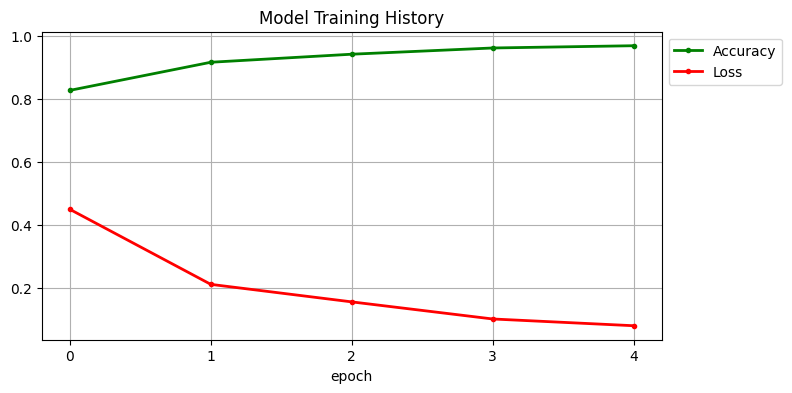

In [11]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)              # Load test images
test_labels_encoded = encode_label(test_labels)    # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# ✅ Convert one-hot labels to class indices if needed
if len(test_labels_encoded.shape) > 1 and test_labels_encoded.shape[1] > 1:
    true_classes = np.argmax(test_labels_encoded, axis=1)
else:
    true_classes = test_labels_encoded

# 2. Classification Report
print("Classification Report:")
print(classification_report(true_classes, np.argmax(test_predictions, axis=1)))


41/41 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       306
           1       0.90      1.00      0.95       300
           2       1.00      1.00      1.00       405
           3       0.99      0.87      0.93       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



Confusion Matrix:
[[276  27   0   3]
 [  1 299   0   0]
 [  0   0 405   0]
 [ 32   5   1 262]]


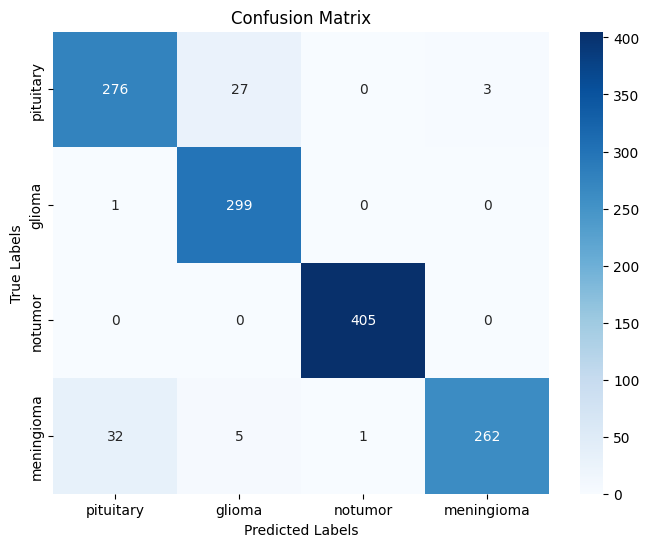

In [13]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

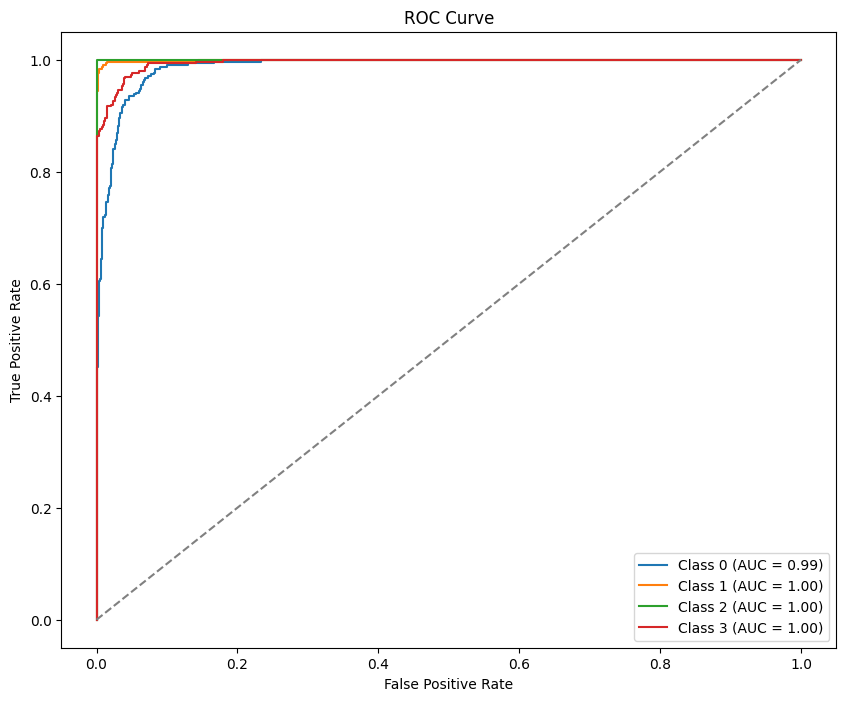

In [14]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [16]:
# Save model in native Keras format (recommended)
model.save("/content/drive/MyDrive/my_model.keras")


In [17]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/drive/MyDrive/my_model.keras", compile=False)


In [18]:
from tensorflow.keras.optimizers import Adam

loaded_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [19]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))
# Example usage

In [27]:
import os

folder = '/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing/glioma'
print(os.listdir(folder))

['Te-pi_0064.jpg', 'Te-pi_0075.jpg', 'Te-pi_0090.jpg', 'Te-pi_0119.jpg', 'Te-pi_0133.jpg', 'Te-pi_0096.jpg', 'Te-pi_0112.jpg', 'Te-pi_0103.jpg', 'Te-pi_0098.jpg', 'Te-piTr_0004.jpg', 'Te-pi_0020.jpg', 'Te-pi_0107.jpg', 'Te-piTr_0005.jpg', 'Te-pi_0030.jpg', 'Te-pi_0083.jpg', 'Te-pi_0073.jpg', 'Te-pi_0062.jpg', 'Te-pi_0043.jpg', 'Te-pi_0106.jpg', 'Te-pi_0124.jpg', 'Te-pi_0082.jpg', 'Te-pi_0058.jpg', 'Te-pi_0059.jpg', 'Te-pi_0066.jpg', 'Te-pi_0041.jpg', 'Te-pi_0015.jpg', 'Te-pi_0131.jpg', 'Te-pi_0102.jpg', 'Te-pi_0054.jpg', 'Te-pi_0060.jpg', 'Te-piTr_0008.jpg', 'Te-pi_0114.jpg', 'Te-piTr_0002.jpg', 'Te-pi_0037.jpg', 'Te-pi_0085.jpg', 'Te-pi_0022.jpg', 'Te-pi_0035.jpg', 'Te-pi_0067.jpg', 'Te-pi_0127.jpg', 'Te-pi_0029.jpg', 'Te-pi_0052.jpg', 'Te-pi_0042.jpg', 'Te-pi_0081.jpg', 'Te-pi_0128.jpg', 'Te-pi_0048.jpg', 'Te-pi_0063.jpg', 'Te-pi_0027.jpg', 'Te-pi_0049.jpg', 'Te-pi_0010.jpg', 'Te-piTr_0007.jpg', 'Te-pi_0069.jpg', 'Te-pi_0050.jpg', 'Te-pi_0108.jpg', 'Te-pi_0129.jpg', 'Te-pi_0071.jpg',

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


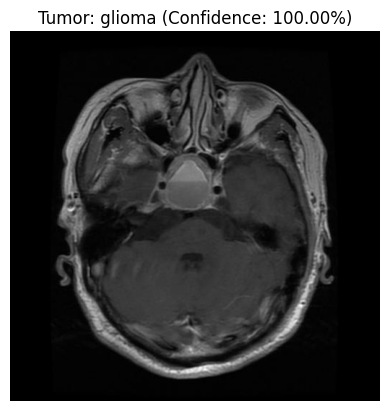

In [ ]:
# Example usage
image_path = '/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing/glioma/Te-pi_0106.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


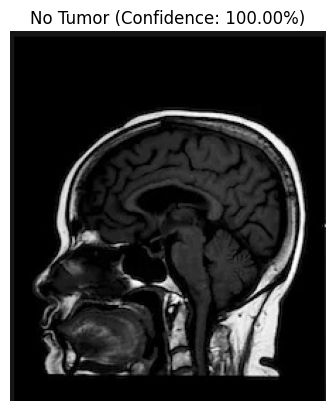

In [35]:
# Example usage
image_path ='/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


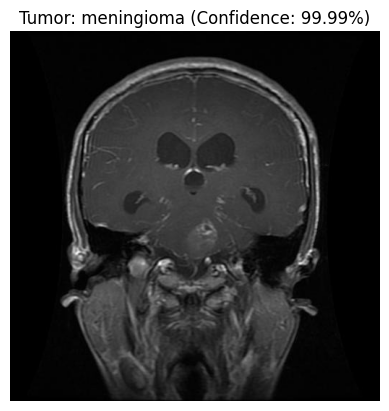

In [ ]:
# Example usage
image_path ='/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing/meningioma/Te-gl_0056.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


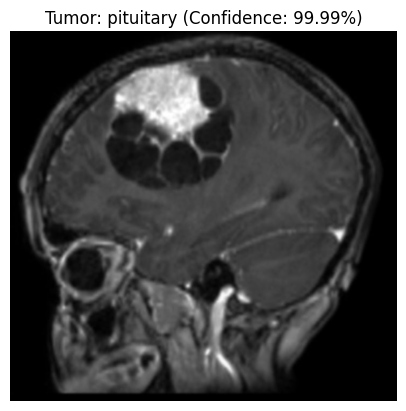

In [43]:
# Example usage
image_path ='/content/drive/MyDrive/Colab Notebooks/Mri Images/Testing/pituitary/Te-me_0067.jpg'  # Corrected filename
detect_and_display(image_path, model)